In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=4

In [3]:
print FOLD

4


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=28

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                    
                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testlstm_l2_{}".format(FOLD), n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type='conv',
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('l2_3003_conv_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1538
0
26 28 (1, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 22s 14ms/step - loss: 0.2834 - total_loss: 0.2834 - reg_loss: 0.2834 - val_loss: 0.2614 - val_total_loss: 0.2614 - val_reg_loss: 0.2614
Epoch 2/100
1538/1538 [==============================] - 22s 14ms/step - loss: 0.2593 - total_loss: 0.2593 - reg_loss: 0.2593 - val_loss:

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.935176 -0.006066  0.235897    7  2017-04-16
472     2.507290  2.547101 -0.039811  0.234544    1  2017-04-17
473     2.661330  2.682867 -0.021537  0.254620    2  2017-04-18
474     2.754815  2.766884 -0.012069  0.210032    3  2017-04-19
475     2.713762  2.713244  0.000518  0.239224    4  2017-04-20
476     2.999000  2.999478 -0.000478  0.154783    5  2017-04-21
477     3.075529  3.094765 -0.019236  0.188163    6  2017-04-22

0.216751966158
best_epochs [4, 6, 3, 5, 7]
(829, 1) 2.68870140344 

2
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1538
0
26 28 (2, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 19s 12ms/step - loss: 0.2801 - total_loss: 0.2801 - reg_loss: 0.2801 - val_loss: 0.2724 - val_total_loss: 0.2724 - val_reg_loss: 0.2724
Epoch 2/100
1538/1538 [==============================] - 23s 15ms/step 

y      pred     error    error2  day        date
dayidx                                                         
470     2.929110  2.933967 -0.004857  0.289668    6  2017-04-15
471     2.507290  2.608404 -0.101114  0.432242    7  2017-04-16
472     2.661330  2.770213 -0.108884  0.367428    1  2017-04-17
473     2.754815  2.776386 -0.021571  0.255214    2  2017-04-18
474     2.713762  2.757535 -0.043773  0.293892    3  2017-04-19
475     2.999000  3.022330 -0.023331  0.205447    4  2017-04-20
476     3.075529  3.087115 -0.011585  0.227513    5  2017-04-21

0.295914928214
best_epochs [3, 5, 8, 6, 7]
(829, 1) 2.51195452836 

3
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 7461 records out of 7461 records
no valid set
1538
0
26 28 (3, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 23s 15ms/step - loss: 0.2814 - total_loss: 0.2814 - reg_loss: 0.2814 - val_loss: 0.2578 - val_total_loss: 0.2578 - val_reg_loss: 0.2578
Epoch 2/100
1538/1538 [==============================] - 21s 14ms/step 

y      pred     error    error2  day        date
dayidx                                                         
469     2.929110  2.911870  0.017240  0.264573    5  2017-04-14
470     2.507290  2.573015 -0.065725  0.306212    6  2017-04-15
471     2.661330  2.691769 -0.030440  0.408883    7  2017-04-16
472     2.754815  2.801597 -0.046782  0.347440    1  2017-04-17
473     2.713762  2.765007 -0.051246  0.311425    2  2017-04-18
474     2.999000  3.001484 -0.002485  0.194893    3  2017-04-19
475     3.075529  3.080194 -0.004665  0.263222    4  2017-04-20

0.299521199688
best_epochs [3, 6, 8, 4, 7]
(829, 1) 2.66955140823 

4
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 8290 records out of 8290 records
no valid set
1538
0
26 28 (4, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 24s 16ms/step - loss: 0.2866 - total_loss: 0.2866 - reg_loss: 0.2866 - val_loss: 0.2637 - val_total_loss: 0.2637 - val_reg_loss: 0.2637
Epoch 2/100
1538/1538 [==============================] - 22s 14ms/step 

y      pred     error    error2  day        date
dayidx                                                         
468     2.929110  2.893905  0.035205  0.316377    4  2017-04-13
469     2.507290  2.539988 -0.032697  0.266321    5  2017-04-14
470     2.661330  2.678002 -0.016672  0.297239    6  2017-04-15
471     2.754815  2.706440  0.048374  0.359736    7  2017-04-16
472     2.713762  2.752320 -0.038558  0.336096    1  2017-04-17
473     2.999000  3.011191 -0.012191  0.211190    2  2017-04-18
474     3.075529  3.037237  0.038292  0.260647    3  2017-04-19

0.292515109998
best_epochs [4, 3, 5, 6, 7]
(829, 1) 2.70817987847 

5
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 9119 records out of 9119 records
no valid set
1538
0
26 28 (5, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 25s 16ms/step - loss: 0.2856 - total_loss: 0.2856 - reg_loss: 0.2856 - val_loss: 0.2566 - val_total_loss: 0.2566 - val_reg_loss: 0.2566
Epoch 2/100
1538/1538 [==============================] - 21s 14ms/step 

y      pred     error    error2  day        date
dayidx                                                         
467     2.929110  2.899089  0.030021  0.344931    3  2017-04-12
468     2.507290  2.565839 -0.058548  0.293287    4  2017-04-13
469     2.661330  2.684308 -0.022978  0.288299    5  2017-04-14
470     2.754815  2.767223 -0.012408  0.260581    6  2017-04-15
471     2.713762  2.730576 -0.016814  0.396499    7  2017-04-16
472     2.999000  2.986160  0.012840  0.282297    1  2017-04-17
473     3.075529  3.051264  0.024265  0.272212    2  2017-04-18

0.30544371986
best_epochs [3, 4, 5, 7, 6]
(829, 1) 2.74468610881 

6
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 15.1334
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 9948 records out of 9948 records
no valid set
1538
0
26 28 (6, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 25s 16ms/step - loss: 0.2882 - total_loss: 0.2882 - reg_loss: 0.2882 - val_loss: 0.2685 - val_total_loss: 0.2685 - val_reg_loss: 0.2685
Epoch 2/100
1538/1538 [==============================] - 24s 16ms/step -

y      pred     error    error2  day        date
dayidx                                                         
466     2.929110  2.914340  0.014770  0.340327    2  2017-04-11
467     2.507290  2.562728 -0.055437  0.318257    3  2017-04-12
468     2.661330  2.702977 -0.041647  0.306551    4  2017-04-13
469     2.754815  2.762745 -0.007930  0.239216    5  2017-04-14
470     2.713762  2.714311 -0.000549  0.284054    6  2017-04-15
471     2.999000  2.917418  0.081581  0.329822    7  2017-04-16
472     3.075529  3.037622  0.037907  0.339482    1  2017-04-17

0.308244080323
best_epochs [3, 5, 6, 2, 8]
(829, 1) 3.00730920041 

7
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 16.3101
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 10777 records out of 10777 records
no valid set
1538
0
26 28 (7, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 22s 14ms/step - loss: 0.2840 - total_loss: 0.2840 - reg_loss: 0.2840 - val_loss: 0.2567 - val_total_loss: 0.2567 - val_reg_loss: 0.2567
Epoch 2/100
1538/1538 [==============================] - 22s 14ms/ste

y      pred     error    error2  day        date
dayidx                                                         
465     2.929110  2.909000  0.020110  0.384863    1  2017-04-10
466     2.507290  2.587649 -0.080358  0.328524    2  2017-04-11
467     2.661330  2.725045 -0.063715  0.331124    3  2017-04-12
468     2.754815  2.782895 -0.028080  0.269654    4  2017-04-13
469     2.713762  2.749310 -0.035549  0.278029    5  2017-04-14
470     2.999000  3.004663 -0.005663  0.208563    6  2017-04-15
471     3.075529  3.095608 -0.020079  0.343904    7  2017-04-16

0.306380126017
best_epochs [3, 8, 4, 2, 5]
(829, 1) 2.99337600723 

8
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 17.5743
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 11606 records out of 11606 records
no valid set
1538
0
26 28 (8, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 24s 15ms/step - loss: 0.2868 - total_loss: 0.2868 - reg_loss: 0.2868 - val_loss: 0.2850 - val_total_loss: 0.2850 - val_reg_loss: 0.2850
Epoch 2/100
1538/1538 [==============================] - 21s 14ms/ste

y      pred     error    error2  day        date
dayidx                                                         
464     2.929110  3.005447 -0.076337  0.362822    7  2017-04-09
465     2.507290  2.616101 -0.108810  0.346375    1  2017-04-10
466     2.661330  2.707042 -0.045712  0.307616    2  2017-04-11
467     2.754815  2.792195 -0.037380  0.294280    3  2017-04-12
468     2.713762  2.751951 -0.038190  0.294088    4  2017-04-13
469     2.999000  2.991196  0.007804  0.176091    5  2017-04-14
470     3.075529  3.115800 -0.040271  0.235585    6  2017-04-15

0.288122524974
best_epochs [5, 4, 7, 8, 2]
(829, 1) 2.78061370353 

9
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 18.8065
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 12435 records out of 12435 records
no valid set
1538
0
26 28 (9, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 22s 14ms/step - loss: 0.2925 - total_loss: 0.2925 - reg_loss: 0.2925 - val_loss: 0.2622 - val_total_loss: 0.2622 - val_reg_loss: 0.2622
Epoch 2/100
1538/1538 [==============================] - 21s 14ms/ste

y      pred     error    error2  day        date
dayidx                                                         
463     2.929110  2.919838  0.009272  0.286370    6  2017-04-08
464     2.507290  2.654430 -0.147140  0.439027    7  2017-04-09
465     2.661330  2.750642 -0.089313  0.382802    1  2017-04-10
466     2.754815  2.768681 -0.013867  0.279937    2  2017-04-11
467     2.713762  2.779595 -0.065833  0.322450    3  2017-04-12
468     2.999000  3.009532 -0.010532  0.202223    4  2017-04-13
469     3.075529  3.080818 -0.005289  0.225021    5  2017-04-14

0.305404205785
best_epochs [4, 6, 9, 3, 5]
(829, 1) 2.56323291477 

10
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 19.9265
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 13264 records out of 13264 records
no valid set
1538
0
26 28 (10, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 22s 14ms/step - loss: 0.2995 - total_loss: 0.2995 - reg_loss: 0.2995 - val_loss: 0.2722 - val_total_loss: 0.2722 - val_reg_loss: 0.2722
Epoch 2/100
1538/1538 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
462     2.929110  2.896830  0.032280  0.282013    5  2017-04-07
463     2.507290  2.550487 -0.043197  0.299015    6  2017-04-08
464     2.661330  2.689646 -0.028316  0.412414    7  2017-04-09
465     2.754815  2.816848 -0.062033  0.347635    1  2017-04-10
466     2.713762  2.756803 -0.043042  0.310395    2  2017-04-11
467     2.999000  2.990432  0.008567  0.217692    3  2017-04-12
468     3.075529  3.072008  0.003521  0.254834    4  2017-04-13

0.303428304381
best_epochs [5, 4, 10, 3, 9]
(829, 1) 2.65930823362 

11
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 21.0577
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 14093 records out of 14093 records
no valid set
1538
0
26 28 (11, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 22s 14ms/step - loss: 0.2956 - total_loss: 0.2956 - reg_loss: 0.2956 - val_loss: 0.2659 - val_total_loss: 0.2659 - val_reg_loss: 0.2659
Epoch 2/100
1538/1538 [==============================] - 21s 14ms/

y      pred     error    error2  day        date
dayidx                                                         
461     2.929110  2.894612  0.034498  0.323965    4  2017-04-06
462     2.507290  2.558182 -0.050892  0.273452    5  2017-04-07
463     2.661330  2.676090 -0.014760  0.317080    6  2017-04-08
464     2.754815  2.743835  0.010980  0.386579    7  2017-04-09
465     2.713762  2.783945 -0.070183  0.374136    1  2017-04-10
466     2.999000  2.982917  0.016083  0.230125    2  2017-04-11
467     3.075529  3.014903  0.060626  0.281549    3  2017-04-12

0.312412065337
best_epochs [5, 4, 3, 2, 6]
(829, 1) 3.03780854933 

12
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 22.1151
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 14922 records out of 14922 records
no valid set
1538
0
26 28 (12, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 25s 16ms/step - loss: 0.2970 - total_loss: 0.2970 - reg_loss: 0.2970 - val_loss: 0.2688 - val_total_loss: 0.2688 - val_reg_loss: 0.2688
Epoch 2/100
1538/1538 [==============================] - 22s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
460     2.929110  2.885808  0.043302  0.324234    3  2017-04-05
461     2.507290  2.558796 -0.051505  0.290912    4  2017-04-06
462     2.661330  2.689860 -0.028530  0.311920    5  2017-04-07
463     2.754815  2.752854  0.001961  0.261972    6  2017-04-08
464     2.713762  2.750072 -0.036310  0.381237    7  2017-04-09
465     2.999000  3.010253 -0.011253  0.256027    1  2017-04-10
466     3.075529  3.059242  0.016287  0.260147    2  2017-04-11

0.298064240994
best_epochs [4, 5, 6, 3, 7]
(829, 1) 2.95070105686 

13
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 23.1552
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 15751 records out of 15751 records
no valid set
1538
0
26 28 (13, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 25s 16ms/step - loss: 0.2978 - total_loss: 0.2978 - reg_loss: 0.2978 - val_loss: 0.2642 - val_total_loss: 0.2642 - val_reg_loss: 0.2642
Epoch 2/100
1538/1538 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
459     2.929110  2.890012  0.039098  0.349200    2  2017-04-04
460     2.507290  2.557355 -0.050065  0.299624    3  2017-04-05
461     2.661330  2.695433 -0.034103  0.314274    4  2017-04-06
462     2.754815  2.736808  0.018007  0.272857    5  2017-04-07
463     2.713762  2.719143 -0.005381  0.291791    6  2017-04-08
464     2.999000  2.924880  0.074120  0.326887    7  2017-04-09
465     3.075529  3.023754  0.051775  0.314751    1  2017-04-10

0.309912098116
best_epochs [5, 7, 4, 6, 2]
(829, 1) 3.10176951382 

14
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 24.2264
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 16580 records out of 16580 records
no valid set
1538
0
26 28 (14, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 25s 16ms/step - loss: 0.2987 - total_loss: 0.2987 - reg_loss: 0.2987 - val_loss: 0.2652 - val_total_loss: 0.2652 - val_reg_loss: 0.2652
Epoch 2/100
1538/1538 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
458     2.929110  2.877574  0.051536  0.409004    1  2017-04-03
459     2.507290  2.550854 -0.043564  0.290105    2  2017-04-04
460     2.661330  2.703949 -0.042619  0.329542    3  2017-04-05
461     2.754815  2.756170 -0.001355  0.275881    4  2017-04-06
462     2.713762  2.763608 -0.049847  0.285898    5  2017-04-07
463     2.999000  3.011873 -0.012873  0.195226    6  2017-04-08
464     3.075529  3.074356  0.001173  0.326805    7  2017-04-09

0.301780280363
best_epochs [6, 5, 4, 9, 2]
(829, 1) 3.10912700851 

15
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 25.3577
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 17409 records out of 17409 records
no valid set
1538
0
26 28 (15, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 24s 16ms/step - loss: 0.2890 - total_loss: 0.2890 - reg_loss: 0.2890 - val_loss: 0.2604 - val_total_loss: 0.2604 - val_reg_loss: 0.2604
Epoch 2/100
1538/1538 [==============================] - 24s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
457     2.929110  2.967658 -0.038548  0.370430    7  2017-04-02
458     2.507290  2.588825 -0.081535  0.338485    1  2017-04-03
459     2.661330  2.672393 -0.011063  0.314611    2  2017-04-04
460     2.754815  2.773531 -0.018717  0.280149    3  2017-04-05
461     2.713762  2.745540 -0.031778  0.299196    4  2017-04-06
462     2.999000  2.975338  0.023661  0.178567    5  2017-04-07
463     3.075529  3.058077  0.017452  0.221961    6  2017-04-08

0.286199784624
best_epochs [6, 2, 8, 5, 4]
(829, 1) 2.71219735091 

16
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 26.4659
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 18238 records out of 18238 records
no valid set
1538
0
26 28 (16, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 22s 14ms/step - loss: 0.2972 - total_loss: 0.2972 - reg_loss: 0.2972 - val_loss: 0.2782 - val_total_loss: 0.2782 - val_reg_loss: 0.2782
Epoch 2/100
1538/1538 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
456     2.929110  2.942705 -0.013595  0.291763    6  2017-04-01
457     2.507290  2.636763 -0.129472  0.445442    7  2017-04-02
458     2.661330  2.733892 -0.072562  0.367080    1  2017-04-03
459     2.754815  2.769858 -0.015044  0.279909    2  2017-04-04
460     2.713762  2.760152 -0.046390  0.320147    3  2017-04-05
461     2.999000  3.002649 -0.003649  0.205588    4  2017-04-06
462     3.075529  3.083437 -0.007908  0.222639    5  2017-04-07

0.304652479141
best_epochs [6, 5, 4, 3, 8]
(829, 1) 2.5498804687 

17
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 27.6058
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 19067 records out of 19067 records
no valid set
1538
0
26 28 (17, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 22s 14ms/step - loss: 0.3020 - total_loss: 0.3020 - reg_loss: 0.3020 - val_loss: 0.2700 - val_total_loss: 0.2700 - val_reg_loss: 0.2700
Epoch 2/100
1538/1538 [==============================] - 22s 14ms/st

y      pred     error    error2  day        date
dayidx                                                         
455     2.929110  2.935924 -0.006814  0.296133    5  2017-03-31
456     2.507290  2.567809 -0.060518  0.295300    6  2017-04-01
457     2.661330  2.723339 -0.062009  0.424138    7  2017-04-02
458     2.754815  2.819986 -0.065171  0.361769    1  2017-04-03
459     2.713762  2.778119 -0.064358  0.331494    2  2017-04-04
460     2.999000  3.027024 -0.028024  0.224077    3  2017-04-05
461     3.075529  3.086247 -0.010718  0.262071    4  2017-04-06

0.313568752593
best_epochs [3, 4, 6, 2, 7]
(829, 1) 2.66450545082 

18
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 28.7513
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 19896 records out of 19896 records
no valid set
1538
0
26 28 (18, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 22s 14ms/step - loss: 0.3057 - total_loss: 0.3057 - reg_loss: 0.3057 - val_loss: 0.2719 - val_total_loss: 0.2719 - val_reg_loss: 0.2719
Epoch 2/100
1538/1538 [==============================] - 21s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
454     2.929110  2.898391  0.030718  0.331211    4  2017-03-30
455     2.507290  2.508977 -0.001686  0.259874    5  2017-03-31
456     2.661330  2.672104 -0.010774  0.318402    6  2017-04-01
457     2.754815  2.733772  0.021042  0.363712    7  2017-04-02
458     2.713762  2.775518 -0.061756  0.356522    1  2017-04-03
459     2.999000  2.982072  0.016927  0.230587    2  2017-04-04
460     3.075529  3.008843  0.066687  0.258342    3  2017-04-05

0.302664201316
best_epochs [6, 4, 8, 3, 5]
(829, 1) 2.70560221434 

19
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 29.7986
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 20725 records out of 20725 records
no valid set
1538
0
26 28 (19, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 22s 14ms/step - loss: 0.3000 - total_loss: 0.3000 - reg_loss: 0.3000 - val_loss: 0.3281 - val_total_loss: 0.3281 - val_reg_loss: 0.3281
Epoch 2/100
1538/1538 [==============================] - 21s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
453     2.929110  2.873440  0.055670  0.350436    3  2017-03-29
454     2.507290  2.562860 -0.055569  0.310532    4  2017-03-30
455     2.661330  2.680753 -0.019423  0.291139    5  2017-03-31
456     2.754815  2.752381  0.002434  0.269495    6  2017-04-01
457     2.713762  2.697349  0.016413  0.391835    7  2017-04-02
458     2.999000  2.962701  0.036298  0.258510    1  2017-04-03
459     3.075529  3.027645  0.047884  0.274576    2  2017-04-04

0.306646094332
best_epochs [6, 4, 2, 3, 7]
(829, 1) 2.71653403187 

20
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 30.7963
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 21554 records out of 21554 records
no valid set
1538
0
26 28 (20, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 22s 14ms/step - loss: 0.3061 - total_loss: 0.3061 - reg_loss: 0.3061 - val_loss: 0.2810 - val_total_loss: 0.2810 - val_reg_loss: 0.2810
Epoch 2/100
1538/1538 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
452     2.929110  2.907314  0.021796  0.363220    2  2017-03-28
453     2.507290  2.600961 -0.093670  0.320096    3  2017-03-29
454     2.661330  2.711831 -0.050501  0.336412    4  2017-03-30
455     2.754815  2.759240 -0.004425  0.255934    5  2017-03-31
456     2.713762  2.785441 -0.071679  0.298630    6  2017-04-01
457     2.999000  2.941037  0.057962  0.337076    7  2017-04-02
458     3.075529  3.046910  0.028619  0.295784    1  2017-04-03

0.315307285812
best_epochs [6, 4, 5, 2, 7]
(829, 1) 2.97604138785 

21
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 31.7929
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 22383 records out of 22383 records
no valid set
1538
0
26 28 (21, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 25s 16ms/step - loss: 0.2976 - total_loss: 0.2976 - reg_loss: 0.2976 - val_loss: 0.2673 - val_total_loss: 0.2673 - val_reg_loss: 0.2673
Epoch 2/100
1538/1538 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
451     2.929110  2.876908  0.052201  0.379739    1  2017-03-27
452     2.507290  2.570138 -0.062847  0.313673    2  2017-03-28
453     2.661330  2.667239 -0.005909  0.334586    3  2017-03-29
454     2.754815  2.760078 -0.005263  0.283541    4  2017-03-30
455     2.713762  2.711600  0.002161  0.272291    5  2017-03-31
456     2.999000  2.956137  0.042863  0.213240    6  2017-04-01
457     3.075529  3.055748  0.019781  0.317785    7  2017-04-02

0.302122460639
best_epochs [5, 7, 6, 8, 2]
(829, 1) 3.01544951084 

22
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 32.871
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 23212 records out of 23212 records
no valid set
1538
0
26 28 (22, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 24s 16ms/step - loss: 0.2935 - total_loss: 0.2935 - reg_loss: 0.2935 - val_loss: 0.2752 - val_total_loss: 0.2752 - val_reg_loss: 0.2752
Epoch 2/100
1538/1538 [==============================] - 21s 14ms/st

y      pred     error    error2  day        date
dayidx                                                         
450     2.929110  2.957471 -0.028361  0.367646    7  2017-03-26
451     2.507290  2.560688 -0.053397  0.333830    1  2017-03-27
452     2.661330  2.694409 -0.033079  0.311940    2  2017-03-28
453     2.754815  2.791415 -0.036601  0.289955    3  2017-03-29
454     2.713762  2.745563 -0.031801  0.330803    4  2017-03-30
455     2.999000  2.951122  0.047877  0.203012    5  2017-03-31
456     3.075529  3.051203  0.024326  0.227357    6  2017-04-01

0.294934631528
best_epochs [5, 4, 7, 6, 3]
(829, 1) 2.72503956581 

23
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 33.9745
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 24041 records out of 24041 records
no valid set
1538
0
26 28 (23, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 21s 14ms/step - loss: 0.3012 - total_loss: 0.3012 - reg_loss: 0.3012 - val_loss: 0.3026 - val_total_loss: 0.3026 - val_reg_loss: 0.3026
Epoch 2/100
1538/1538 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
449     2.929110  2.949251 -0.020141  0.310236    6  2017-03-25
450     2.507290  2.638402 -0.131112  0.449821    7  2017-03-26
451     2.661330  2.774486 -0.113156  0.379281    1  2017-03-27
452     2.754815  2.794769 -0.039954  0.281756    2  2017-03-28
453     2.713762  2.771526 -0.057764  0.319571    3  2017-03-29
454     2.999000  2.989462  0.009538  0.215674    4  2017-03-30
455     3.075529  3.038316  0.037213  0.212219    5  2017-03-31

0.309793975788
best_epochs [4, 3, 7, 8, 6]
(829, 1) 2.47227316363 

24
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 35.2084
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 24870 records out of 24870 records
no valid set
1538
0
26 28 (24, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 21s 14ms/step - loss: 0.3064 - total_loss: 0.3064 - reg_loss: 0.3064 - val_loss: 0.2807 - val_total_loss: 0.2807 - val_reg_loss: 0.2807
Epoch 2/100
1538/1538 [==============================] - 23s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
448     2.929110  2.893271  0.035839  0.297179    5  2017-03-24
449     2.507290  2.523928 -0.016637  0.294542    6  2017-03-25
450     2.661330  2.704223 -0.042893  0.423099    7  2017-03-26
451     2.754815  2.789777 -0.034962  0.347962    1  2017-03-27
452     2.713762  2.738414 -0.024652  0.309469    2  2017-03-28
453     2.999000  2.992445  0.006555  0.219018    3  2017-03-29
454     3.075529  3.023585  0.051944  0.243071    4  2017-03-30

0.304905771074
best_epochs [4, 5, 3, 7, 8]
(829, 1) 2.56275037762 

25
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 36.3351
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 25699 records out of 25699 records
no valid set
1538
0
26 28 (25, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 20s 13ms/step - loss: 0.3061 - total_loss: 0.3061 - reg_loss: 0.3061 - val_loss: 0.2727 - val_total_loss: 0.2727 - val_reg_loss: 0.2727
Epoch 2/100
1538/1538 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
447     2.929110  2.878412  0.050698  0.333500    4  2017-03-23
448     2.507290  2.539548 -0.032257  0.283203    5  2017-03-24
449     2.661330  2.683663 -0.022334  0.306184    6  2017-03-25
450     2.754815  2.719019  0.035796  0.382599    7  2017-03-26
451     2.713762  2.762680 -0.048918  0.357118    1  2017-03-27
452     2.999000  2.976064  0.022936  0.220869    2  2017-03-28
453     3.075529  3.023118  0.052411  0.265889    3  2017-03-29

0.307051470005
best_epochs [6, 5, 3, 7, 4]
(829, 1) 2.66605215917 

26
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 37.3741
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 26528 records out of 26528 records
no valid set
1538
0
26 28 (26, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 21s 14ms/step - loss: 0.3067 - total_loss: 0.3067 - reg_loss: 0.3067 - val_loss: 0.2765 - val_total_loss: 0.2765 - val_reg_loss: 0.2765
Epoch 2/100
1538/1538 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
446     2.929110  2.890709  0.038401  0.376654    3  2017-03-22
447     2.507290  2.532196 -0.024905  0.310218    4  2017-03-23
448     2.661330  2.677954 -0.016624  0.309705    5  2017-03-24
449     2.754815  2.741858  0.012956  0.265714    6  2017-03-25
450     2.713762  2.700474  0.013287  0.392682    7  2017-03-26
451     2.999000  2.978561  0.020439  0.263669    1  2017-03-27
452     3.075529  3.029961  0.045569  0.282267    2  2017-03-28

0.314415749472
best_epochs [4, 3, 5, 6, 8]
(829, 1) 2.69448880056 

27
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 38.4506
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 27357 records out of 27357 records
no valid set
1538
0
26 28 (27, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 21s 14ms/step - loss: 0.3066 - total_loss: 0.3066 - reg_loss: 0.3066 - val_loss: 0.2985 - val_total_loss: 0.2985 - val_reg_loss: 0.2985
Epoch 2/100
1538/1538 [==============================] - 19s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
445     2.929110  2.852744  0.076366  0.379759    2  2017-03-21
446     2.507290  2.566716 -0.059425  0.308702    3  2017-03-22
447     2.661330  2.683460 -0.022130  0.333731    4  2017-03-23
448     2.754815  2.758021 -0.003206  0.281267    5  2017-03-24
449     2.713762  2.757721 -0.043959  0.300322    6  2017-03-25
450     2.999000  2.945873  0.053127  0.332838    7  2017-03-26
451     3.075529  3.055080  0.020450  0.304320    1  2017-03-27

0.320134136098
best_epochs [6, 2, 3, 5, 4]
(829, 1) 2.98639365417 

28
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 39.4798
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 28186 records out of 28186 records
no valid set
1538
0
26 28 (28, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 24s 16ms/step - loss: 0.3032 - total_loss: 0.3032 - reg_loss: 0.3032 - val_loss: 0.2736 - val_total_loss: 0.2736 - val_reg_loss: 0.2736
Epoch 2/100
1538/1538 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
444     2.929110  2.989482 -0.060372  0.430746    1  2017-03-20
445     2.507290  2.592592 -0.085302  0.347037    2  2017-03-21
446     2.661330  2.694206 -0.032876  0.323771    3  2017-03-22
447     2.754815  2.738316  0.016498  0.280145    4  2017-03-23
448     2.713762  2.742662 -0.028901  0.299579    5  2017-03-24
449     2.999000  2.958403  0.040597  0.211644    6  2017-03-25
450     3.075529  3.047708  0.027821  0.336474    7  2017-03-26

0.318485086242
best_epochs [4, 5, 3, 6, 8]
(829, 1) 3.04884903958 

29
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 40.7934
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 29015 records out of 29015 records
no valid set
1538
0
26 28 (29, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 22s 14ms/step - loss: 0.2968 - total_loss: 0.2968 - reg_loss: 0.2968 - val_loss: 0.2710 - val_total_loss: 0.2710 - val_reg_loss: 0.2710
Epoch 2/100
1538/1538 [==============================] - 24s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
443     2.929110  2.947294 -0.018184  0.329725    7  2017-03-19
444     2.507290  2.620744 -0.113454  0.440262    1  2017-03-20
445     2.661330  2.724578 -0.063248  0.341037    2  2017-03-21
446     2.754815  2.747481  0.007333  0.296321    3  2017-03-22
447     2.713762  2.739211 -0.025449  0.312843    4  2017-03-23
448     2.999000  2.980605  0.018394  0.191377    5  2017-03-24
449     3.075529  3.069942  0.005587  0.221788    6  2017-03-25

0.304764892327
best_epochs [4, 2, 6, 3, 7]
(829, 1) 2.78187005629 

30
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 41.9859
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 29844 records out of 29844 records
no valid set
1538
0
26 28 (30, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 21s 13ms/step - loss: 0.3041 - total_loss: 0.3041 - reg_loss: 0.3041 - val_loss: 0.2760 - val_total_loss: 0.2760 - val_reg_loss: 0.2760
Epoch 2/100
1538/1538 [==============================] - 23s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
442     2.929110  2.897492  0.031618  0.311202    6  2017-03-18
443     2.507290  2.600959 -0.093668  0.407538    7  2017-03-19
444     2.661330  2.738675 -0.077345  0.426414    1  2017-03-20
445     2.754815  2.788660 -0.033845  0.313723    2  2017-03-21
446     2.713762  2.743165 -0.029403  0.312920    3  2017-03-22
447     2.999000  2.967749  0.031251  0.215328    4  2017-03-23
448     3.075529  3.066603  0.008926  0.233869    5  2017-03-24

0.317284815767
best_epochs [4, 7, 3, 5, 6]
(829, 1) 2.51209957769 

31
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 43.2281
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 30673 records out of 30673 records
no valid set
1538
0
26 28 (31, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 22s 14ms/step - loss: 0.3090 - total_loss: 0.3090 - reg_loss: 0.3090 - val_loss: 0.2839 - val_total_loss: 0.2839 - val_reg_loss: 0.2839
Epoch 2/100
1538/1538 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
441     2.929110  2.891613  0.037497  0.307250    5  2017-03-17
442     2.507290  2.541048 -0.033758  0.313744    6  2017-03-18
443     2.661330  2.670658 -0.009328  0.401842    7  2017-03-19
444     2.754815  2.757292 -0.002477  0.399161    1  2017-03-20
445     2.713762  2.766480 -0.052718  0.336666    2  2017-03-21
446     2.999000  3.006626 -0.007627  0.220657    3  2017-03-22
447     3.075529  3.059821  0.015708  0.267699    4  2017-03-23

0.321002503894
best_epochs [6, 4, 5, 7, 3]
(829, 1) 2.63374697833 

32
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 44.4464
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 31502 records out of 31502 records
no valid set
1538
0
26 28 (32, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 24s 16ms/step - loss: 0.3101 - total_loss: 0.3101 - reg_loss: 0.3101 - val_loss: 0.2922 - val_total_loss: 0.2922 - val_reg_loss: 0.2922
Epoch 2/100
1538/1538 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
440     2.929110  2.877173  0.051937  0.343428    4  2017-03-16
441     2.507290  2.542063 -0.034773  0.274821    5  2017-03-17
442     2.661330  2.672199 -0.010870  0.324942    6  2017-03-18
443     2.754815  2.756834 -0.002020  0.370882    7  2017-03-19
444     2.713762  2.806005 -0.092243  0.413839    1  2017-03-20
445     2.999000  2.985025  0.013975  0.243739    2  2017-03-21
446     3.075529  3.062306  0.013223  0.291415    3  2017-03-22

0.323295227697
best_epochs [6, 4, 8, 7, 5]
(829, 1) 2.74768195066 

33
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 45.5115
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 32331 records out of 32331 records
no valid set
1538
0
26 28 (33, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 25s 16ms/step - loss: 0.3103 - total_loss: 0.3103 - reg_loss: 0.3103 - val_loss: 0.2821 - val_total_loss: 0.2821 - val_reg_loss: 0.2821
Epoch 2/100
1538/1538 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
439     2.929110  2.879656  0.049454  0.359255    3  2017-03-15
440     2.507290  2.547655 -0.040364  0.294340    4  2017-03-16
441     2.661330  2.671477 -0.010147  0.308988    5  2017-03-17
442     2.754815  2.739395  0.015419  0.269071    6  2017-03-18
443     2.713762  2.747676 -0.033915  0.394604    7  2017-03-19
444     2.999000  2.912518  0.086482  0.360111    1  2017-03-20
445     3.075529  3.018472  0.057058  0.322128    2  2017-03-21

0.329785527046
best_epochs [3, 6, 4, 5, 8]
(829, 1) 2.75687375224 

34
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 46.5688
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 33160 records out of 33160 records
no valid set
1538
0
26 28 (34, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 24s 16ms/step - loss: 0.3106 - total_loss: 0.3106 - reg_loss: 0.3106 - val_loss: 0.2850 - val_total_loss: 0.2850 - val_reg_loss: 0.2850
Epoch 2/100
1538/1538 [==============================] - 24s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
438     2.929110  2.890190  0.038920  0.351890    2  2017-03-14
439     2.507290  2.554454 -0.047164  0.308064    3  2017-03-15
440     2.661330  2.676892 -0.015562  0.314825    4  2017-03-16
441     2.754815  2.733648  0.021167  0.258259    5  2017-03-17
442     2.713762  2.700767  0.012995  0.298706    6  2017-03-18
443     2.999000  2.935059  0.063940  0.317123    7  2017-03-19
444     3.075529  3.043533  0.031996  0.341929    1  2017-03-20

0.312970901268
best_epochs [6, 3, 2, 5, 4]
(829, 1) 2.98986637488 

35
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 47.4733
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 33989 records out of 33989 records
no valid set
1538
0
26 28 (35, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 24s 16ms/step - loss: 0.3064 - total_loss: 0.3064 - reg_loss: 0.3064 - val_loss: 0.2915 - val_total_loss: 0.2915 - val_reg_loss: 0.2915
Epoch 2/100
1538/1538 [==============================] - 24s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
437     2.929110  2.898737  0.030373  0.394530    1  2017-03-13
438     2.507290  2.544428 -0.037138  0.320447    2  2017-03-14
439     2.661330  2.655894  0.005436  0.316714    3  2017-03-15
440     2.754815  2.752244  0.002570  0.288832    4  2017-03-16
441     2.713762  2.710347  0.003414  0.291696    5  2017-03-17
442     2.999000  2.942670  0.056330  0.228551    6  2017-03-18
443     3.075529  3.107618 -0.032089  0.309732    7  2017-03-19

0.307214478085
best_epochs [4, 3, 5, 6, 2]
(829, 1) 3.08358672167 

36
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 48.7491
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 34818 records out of 34818 records
no valid set
1538
0
26 28 (36, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 25s 16ms/step - loss: 0.3021 - total_loss: 0.3021 - reg_loss: 0.3021 - val_loss: 0.2700 - val_total_loss: 0.2700 - val_reg_loss: 0.2700
Epoch 2/100
1538/1538 [==============================] - 24s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
436     2.929110  3.001747 -0.072637  0.374260    7  2017-03-12
437     2.507290  2.619122 -0.111831  0.331630    1  2017-03-13
438     2.661330  2.729621 -0.068292  0.303748    2  2017-03-14
439     2.754815  2.779759 -0.024944  0.285435    3  2017-03-15
440     2.713762  2.746727 -0.032965  0.297897    4  2017-03-16
441     2.999000  2.988520  0.010479  0.203065    5  2017-03-17
442     3.075529  3.126915 -0.051385  0.236808    6  2017-03-18

0.29040628435
best_epochs [3, 6, 7, 1, 2]
(829, 1) 2.79977389503 

37
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 49.8797
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 35647 records out of 35647 records
no valid set
1538
0
26 28 (37, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 22s 14ms/step - loss: 0.3088 - total_loss: 0.3088 - reg_loss: 0.3088 - val_loss: 0.2789 - val_total_loss: 0.2789 - val_reg_loss: 0.2789
Epoch 2/100
1538/1538 [==============================] - 23s 15ms/st

y      pred     error    error2  day        date
dayidx                                                         
435     2.929110  2.898877  0.030233  0.300341    6  2017-03-11
436     2.507290  2.668358 -0.161067  0.468936    7  2017-03-12
437     2.661330  2.756119 -0.094789  0.395849    1  2017-03-13
438     2.754815  2.771360 -0.016545  0.308955    2  2017-03-14
439     2.713762  2.761879 -0.048117  0.321836    3  2017-03-15
440     2.999000  2.989389  0.009611  0.228477    4  2017-03-16
441     3.075529  3.074729  0.000800  0.241879    5  2017-03-17

0.323753567164
best_epochs [6, 5, 4, 7, 1]
(829, 1) 2.56749099227 

38
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 51.0865
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 36476 records out of 36476 records
no valid set
1538
0
26 28 (38, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 23s 15ms/step - loss: 0.3173 - total_loss: 0.3173 - reg_loss: 0.3173 - val_loss: 0.3047 - val_total_loss: 0.3047 - val_reg_loss: 0.3047
Epoch 2/100
1538/1538 [==============================] - 22s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
434     2.929110  2.886965  0.042145  0.324183    5  2017-03-10
435     2.507290  2.522665 -0.015374  0.308700    6  2017-03-11
436     2.661330  2.704413 -0.043083  0.430545    7  2017-03-12
437     2.754815  2.794920 -0.040105  0.365451    1  2017-03-13
438     2.713762  2.742901 -0.029140  0.317370    2  2017-03-14
439     2.999000  2.933972  0.065027  0.223262    3  2017-03-15
440     3.075529  3.048962  0.026568  0.259122    4  2017-03-16

0.318375809171
best_epochs [4, 5, 3, 2, 6]
(829, 1) 2.69290948026 

39
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 52.0488
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (298136, 2) (74085, 2)
train/valid # (196947, 2) (48345, 2)
train/valid # (196947, 2) (48345, 2)
rand split across time
train has 196947 records out of 372221 records
valid has 48345 records out of 372221 records
train has 37305 records out of 37305 records
no valid set
1538
0
26 28 (39, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1538/1538 [==============================] - 20s 13ms/step - loss: 0.3140 - total_loss: 0.3140 - reg_loss: 0.3140 - val_loss: 0.3076 - val_total_loss: 0.3076 - val_reg_loss: 0.3076
Epoch 2/100
1538/1538 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
433     2.929110  2.901086  0.028024  0.337879    4  2017-03-09
434     2.507290  2.584617 -0.077327  0.278347    5  2017-03-10
435     2.661330  2.682722 -0.021393  0.313042    6  2017-03-11
436     2.754815  2.736513  0.018302  0.368195    7  2017-03-12
437     2.713762  2.759566 -0.045805  0.347156    1  2017-03-13
438     2.999000  2.962425  0.036575  0.244362    2  2017-03-14
439     3.075529  3.018822  0.056707  0.278738    3  2017-03-15

0.309674108091
best_epochs [4, 2, 5, 6, 3]
(829, 1) 2.7738940244


In [27]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

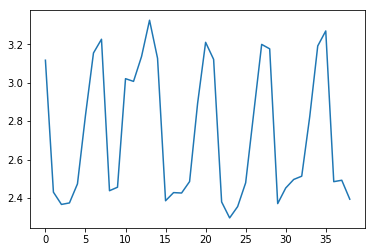

In [28]:
plt.plot(testpreds[129])

In [29]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [30]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.864385   
air_0164b9927d20bcc3_2017-04-23              1.473909   
air_0241aa3964b7f861_2017-04-23              2.317352   
air_0328696196e46f18_2017-04-23              2.114769   
air_034a3d5b40d5b1b1_2017-04-23              3.537679   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.451965  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.366268  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.148765  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.287669  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  33.387010

In [31]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [32]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [33]:
submission.to_csv("../submission/l2_3003_conv_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')